# Hexxed Graph Environment

In [87]:
import math
from collections import defaultdict

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from neuronav.agents.dyna_agents import DynaQ
from neuronav.envs.graph_env import GraphEnv, GraphObservation
from neuronav.envs.graph_templates import GraphTemplate, HexxedGraph
from neuronav.utils import run_episode

In [88]:
g = HexxedGraph()
g.visualize()
g.edges

                     00
 1  2  3  4  5  6 |  07    <--  Layer 01
 8  9 10 11 12 13 |  14    <--  Layer 02
15 16 17 18 19 20 |  21    <--  Layer 03
22 23 24 25 26 27 |  28    <--  Layer 04
29 30 31 32 33 34 |  35    <--  Layer 05
36 37 38 39 40 41 |  42    <--  Layer 06
                     43


{0: [1, 2, 3, 4, 5, 6],
 1: [13, 8, 9],
 2: [8, 9, 10],
 3: [9, 10, 11],
 4: [10, 11, 12],
 5: [11, 12, 13],
 6: [12, 13, 8, 7],
 7: [],
 8: [20, 15, 16],
 9: [15, 16, 17],
 10: [16, 17, 18],
 11: [17, 18, 19],
 12: [18, 19, 20],
 13: [19, 20, 15, 14],
 14: [],
 15: [27, 22, 23],
 16: [22, 23, 24],
 17: [23, 24, 25],
 18: [24, 25, 26],
 19: [25, 26, 27],
 20: [26, 27, 22, 21],
 21: [],
 22: [34, 29, 30],
 23: [29, 30, 31],
 24: [30, 31, 32],
 25: [31, 32, 33],
 26: [32, 33, 34],
 27: [33, 34, 29, 28],
 28: [],
 29: [41, 36, 37],
 30: [36, 37, 38],
 31: [37, 38, 39],
 32: [38, 39, 40],
 33: [39, 40, 41],
 34: [40, 41, 36, 35],
 35: [],
 36: [43],
 37: [43],
 38: [43],
 39: [43],
 40: [43],
 41: [43, 42],
 42: [],
 43: []}

DynaQ Episode 0 ==> 0.00% complete
DynaQ Episode 1 ==> 1.00% complete
DynaQ Episode 2 ==> 2.00% complete
DynaQ Episode 3 ==> 3.00% complete
DynaQ Episode 4 ==> 4.00% complete
DynaQ Episode 5 ==> 5.00% complete
DynaQ Episode 6 ==> 6.00% complete
DynaQ Episode 7 ==> 7.00% complete
DynaQ Episode 8 ==> 8.00% complete
DynaQ Episode 9 ==> 9.00% complete
DynaQ Episode 10 ==> 10.00% complete
DynaQ Episode 11 ==> 11.00% complete
DynaQ Episode 12 ==> 12.00% complete
DynaQ Episode 13 ==> 13.00% complete
DynaQ Episode 14 ==> 14.00% complete
DynaQ Episode 15 ==> 15.00% complete
DynaQ Episode 16 ==> 16.00% complete
DynaQ Episode 17 ==> 17.00% complete
DynaQ Episode 18 ==> 18.00% complete
DynaQ Episode 19 ==> 19.00% complete
DynaQ Episode 20 ==> 20.00% complete
DynaQ Episode 21 ==> 21.00% complete
DynaQ Episode 22 ==> 22.00% complete
DynaQ Episode 23 ==> 23.00% complete
DynaQ Episode 24 ==> 24.00% complete
DynaQ Episode 25 ==> 25.00% complete
DynaQ Episode 26 ==> 26.00% complete
DynaQ Episode 27 ==> 

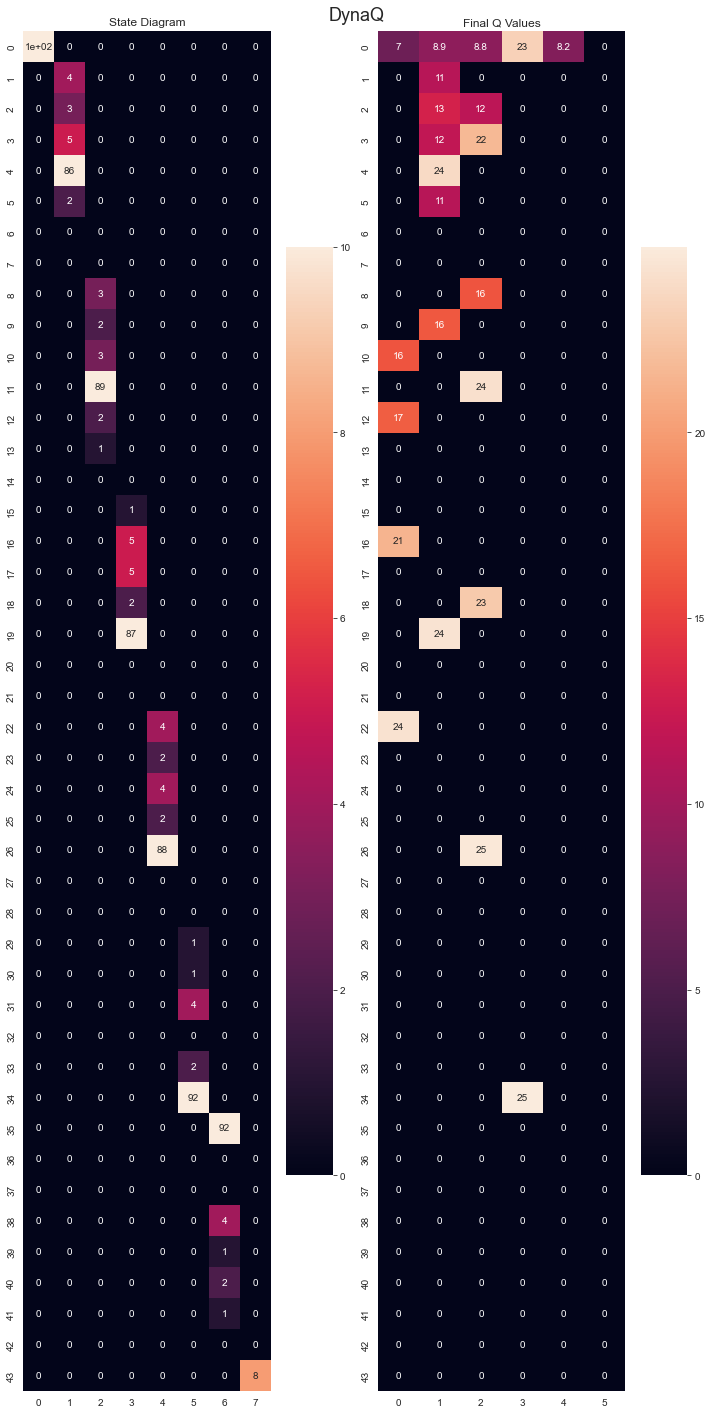

In [89]:
TITLESIZE = 28
AXISSIZE = 20
NUM_EPS = 100
MAX_STEPS = 8
VERSION = 1
SAVE_FIG = False

env = GraphEnv(GraphTemplate.hexxed,
               obs_type=GraphObservation.index)
obs = env.reset()

agents = {
	# "TDQ": TDQ(env.state_size, env.action_space.n, epsilon=0.5),
	"DynaQ": DynaQ(env.state_size, env.action_space.n, epsilon=0.2),
	# "SARSA": SARSA(env.state_size, env.action_space.n)
}

learning_curves = defaultdict(list)

for agent_name in agents.keys():

	agent = agents[agent_name]
	state_diagram = np.zeros((env.state_size, MAX_STEPS))

	for i in range(NUM_EPS):
		print(f"{agent_name} Episode {i} ==> {float(i) / NUM_EPS:.02%} complete")
		agent, steps, ep_return, moves = run_episode(env=env,
		                                             agent=agent,
		                                             max_steps=MAX_STEPS,
		                                             return_moves=True)

		moves_arr = (np.eye(env.state_size)[moves].T)

		moves_h, moves_w = moves_arr.shape
		state_diagram[: moves_h, : moves_w] += moves_arr

		learning_curves[agent_name].append(ep_return)

	fig, axs = plt.subplots(ncols=2, figsize=(10, 20))

	fig.suptitle(agent_name, fontsize=18)

	axs[0].set_title(f"State Diagram")
	axs[0].set_xlabel("Time")
	axs[0].set_ylabel("Next Node")
	sns.heatmap(state_diagram,
	            ax=axs[0], vmax=NUM_EPS // 10,
	            annot=True)

	axs[1].set_title(f"Final Q Values")
	axs[1].set_xlabel("Action")
	axs[1].set_ylabel("Node")
	sns.heatmap(agent.Q.T, ax=axs[1], annot=True)

	fig.tight_layout()
	if SAVE_FIG:
		plt.savefig(f"figures/{agent_name}_{NUM_EPS}_v{VERSION}.png", dpi=300)

Text(0.5, 1.0, 'DynaQ')

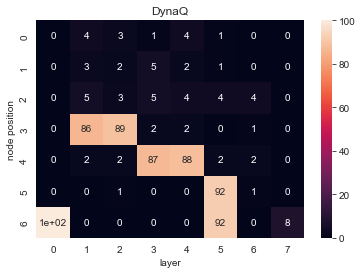

In [90]:
square_state_diagram = np.zeros((8, 8))

layers_map = {n: (math.ceil(n / 7), n % 7) if n % 7 != 0 else (math.ceil(n / 7), 7) for n in range(43)}
layers_map[43] = (7, 7)

flat_state_diagram = np.sum(state_diagram, axis=1)

for n in range(flat_state_diagram.shape[0]):
	layer, pos = layers_map[n]
	square_state_diagram[pos, layer] = flat_state_diagram[n]

sns.heatmap(square_state_diagram[1:], annot=True)
plt.xlabel('layer')
plt.ylabel('node position')
plt.title(agent_name)

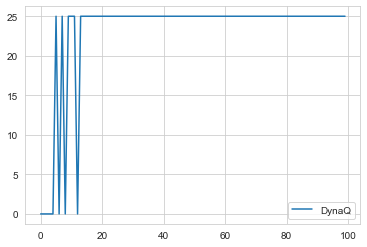

In [91]:
for agent_name in learning_curves:
	plt.plot(range(100), learning_curves[agent_name], label=agent_name)
	plt.legend(loc='best')